# Mining genetic, transcriptomic and imaging data in Parkinson’s disease - 1 

In [55]:
from matplotlib_venn import venn3
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import subprocess
import math
import sys
import os

## Introduction

#### Required softwares

- Plink (v1.9b)

#### Data description
PPMI genoptyping data are stored in PLINK file format. They are stored in two genotyping datasets:

- IMMUNO

- NEUROX

IMMUNO dataset targets genetic loci that are known to be associated with major autoimmune and neuroinflammatory diseases. It contains 196,524 genetic variants: 718 indels and 195,806 SNPs. Among these genetic variants, 1920 SNPs replicates PD associated genetic loci.

NeuroX dataset targets ~240,000 exonic genomic variants and ~24,000 custom variants, involved in neurological diseases.

Both datasets provides 3 files:
- BED
- BIM
- FAM

#### PLINK BIM
Plink BIM is a text file with no header, and one line per variant with the following six fields:
- Chromosome code (either an integer, or 'X'/'Y'/'XY'/'MT'; '0' indicates unknown) or name
- Variant identifier
- Position in morgans or centimorgans
- Base-pair coordinate (1-based)
- Allele 1 (usually minor)
- Allele 2 (usually major)

#### PLINK FAM
Plink FAM is a text file with no header, and one line per sample with the following six fields:
- Family ID ('FID')
- Within-family ID ('IID'; cannot be '0')
- Within-family ID of father ('0' if father isn't in dataset)
- Within-family ID of mother ('0' if mother isn't in dataset)
- Sex code ('1' = male, '2' = female, '0' = unknown)
- Phenotype value ('1' = control, '2' = case, '-9'/'0'/non-numeric = missing data if case/control)

#### PLINK BED
Plink BED file is the primary representation of genotype calls at biallelic variants. It must be accompanied by .bim and .fam files. Plink BED file is binary, its human-readable version is the PED file (for further information see [here](https://www.cog-genomics.org/plink/1.9/formats#ped)).

In [45]:
genotyping_path = "data/genotyping/"
pheno_path = "data/pheno/"
immuno_path = os.path.join(genotyping_path, "IMMUNO")
neurox_path = os.path.join(genotyping_path, "NEUROX")
hapmap_path = os.path.join(genotyping_path, "HapMap3_b37")

## A first glimpse at data

In [3]:
immuno_bim = pd.read_csv(
    os.path.join(immuno_path, "IMMUNO.bim"), 
    header=None,
    sep="\t"
)
immuno_bim.head()

,0,1,2,3,4,5
0,1,imm_1_898835,0,898835,0,A
1,1,vh_1_1108138,0,1108138,T,C
2,1,vh_1_1110294,0,1110294,A,G
3,1,rs9729550,0,1125105,C,A
4,1,rs1815606,0,1130298,T,G


In [72]:
neurox_bim = pd.read_csv(
    os.path.join(neurox_path, "NEUROX.bim"),
    header=None,
    sep="\t"
)
neurox_bim.tail()

,0,1,2,3,4,5
267602,26,exm2216497,0,15942,0,T
267603,26,exm2216498,0,15946,T,C
267604,26,exm2216499,0,15951,G,A
267605,26,exm2216500,0,15978,T,C
267606,26,exm-rs41378955,0,16390,0,0


IMMUNO variant rs9729550 should be mapped at position 1135242 in hg19 release. <br>
If it was mapped on hg18 release it should be mapped at position 1125105. <br>
Therefore, IMMUNO SNPs have been mapped on hg18 assembly!

Moreover, NEUROX SNPs have been mapped on hg19 release.

This means that we need to lift IMMUNO SNPs positions. Let's do it with Plink and UCSC genome browser tools!

First, we need to encode IMMUNO's BIM in a format that the UCSC genome browser can understand: UCSC BED format: 

```chrom start stop name```

In [5]:
# minimal UCSC BED file requires
#
# CHROM    START    STOP    FEATURE_ID 

tmp_chr = immuno_bim.iloc[:,0]  # chromosomes
tmp_pos = immuno_bim.iloc[:,3]  # SNP positions
tmp_name = immuno_bim.iloc[:,1] # SNP IDs

# append 'chr' in front of chromosome numbers (required by liftOver)
tmp_chr_str = [''.join(["chr", str(c)]) for c in tmp_chr.values]

# replace chr23, chr24, chr25 and chr26 with chrX, chrY, chrX and chrMT
tmp_chr_str2 = [c.replace('23', 'X') for c in tmp_chr_str]
tmp_chr_str3 = [c.replace('24', 'Y') for c in tmp_chr_str2]
tmp_chr_str4 = [c.replace('25', 'X') for c in tmp_chr_str3]
tmp_chr_str5 = [c.replace('26', 'MT') for c in tmp_chr_str4]

# write the resulting UCSC BED file
bed = pd.concat(
    [pd.DataFrame(tmp_chr_str5), tmp_pos, tmp_pos + 1, tmp_name],
    axis=1
)
print(bed.head(n=5))
print(bed.tail(n=5))
bed.to_csv(
    os.path.join(immuno_path, "IMMUNO_tolift.bed"), sep="\t",
    index=False, header=False
)

      0        3        3             1
0  chr1   898835   898836  imm_1_898835
1  chr1  1108138  1108139  vh_1_1108138
2  chr1  1110294  1110295  vh_1_1110294
3  chr1  1125105  1125106     rs9729550
4  chr1  1130298  1130299     rs1815606
            0          3          3           1
196519   chrX  154889906  154889907   rs3093525
196520   chrX  154889917  154889918   rs3093526
196521   chrX  154892630  154892631   rs2742301
196522   chrX  154907376  154907377   rs2981835
196523  chrMT       3721       3722  MitoA3721G


Let's now use [LiftOver](http://genome.ucsc.edu/cgi-bin/hgLiftOver) tool from UCSC genome browser to lift IMMUNO SNPs positions from hg18 to hg19 genome release. Some SNPs will not be converted (four), but we can ignore it.

In [6]:
bed_lifted = pd.read_csv(os.path.join(immuno_path, "IMMUNO_lifted.bed"), sep="\t", header=None)

# we keep succesfully mapped SNPs
good_snps = bed_lifted.iloc[:,3]
good_snps.to_csv(
    os.path.join(immuno_path, "good_snps.txt"),
    index=False, header=False
)

# call plink from command line
!plink --bfile {os.path.join(immuno_path, "IMMUNO")} --update-map {os.path.join(immuno_path, "IMMUNO_lifted.bed")} 2 4 --make-bed --extract {os.path.join(immuno_path, "good_snps.txt")} --out {os.path.join(immuno_path, "IMMUNO_hg19")}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/IMMUNO/IMMUNO_hg19.log.
Options in effect:
  --bfile data/genotyping/IMMUNO/IMMUNO
  --extract data/genotyping/IMMUNO/good_snps.txt
  --make-bed
  --out data/genotyping/IMMUNO/IMMUNO_hg19
  --update-map data/genotyping/IMMUNO/IMMUNO_lifted.bed 2 4

16384 MB RAM detected; reserving 8192 MB for main workspace.
196524 variants loaded from .bim file.
523 people (343 males, 180 females) loaded from .fam.
--update-map: 196520 values updated.
--extract: 196520 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 523 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

In [13]:
immuno_hg19_bim = pd.read_csv(
    os.path.join(immuno_path, "IMMUNO_hg19.bim"),
    sep="\t",
    header=None
)
immuno_hg19_bim.head()

,0,1,2,3,4,5
0,1,imm_1_898835,0,908972,0,A
1,1,vh_1_1108138,0,1118275,T,C
2,1,vh_1_1110294,0,1120431,A,G
3,1,rs9729550,0,1135242,C,A
4,1,rs1815606,0,1140435,T,G


Now rs9729550 is correctly mapped at position 1135242!

Next we will create a single dataset combining IMMUNO and NEUROX datasets. Plink will help us doing this!

In [9]:
immuno_fam = pd.read_csv(
    os.path.join(immuno_path, "IMMUNO_hg19.fam"), 
    sep=" ", 
    header=None
)
neurox_fam = pd.read_csv(
    os.path.join(neurox_path, "NEUROX.fam"), 
    sep=" ", 
    header=None
)
# recover subjects IDs
immuno_subj = immuno_fam.iloc[:,1].tolist()
neurox_subj = neurox_fam.iloc[:,1].tolist()

# retrieve subjects with data in both IMMUNO and NEUROX 
common_subj = set(immuno_subj).intersection(set(neurox_subj))

# write common subjects to file
common_subj_fn = "data/genotyping/common_subj.txt"
pd.DataFrame(list(zip(common_subj, common_subj)), columns=["FID", "IID"]).to_csv(
    common_subj_fn,
    header=False,
    index=False,
    sep=" "
)

# call plink on IMMUNO
!plink --bfile {os.path.join(immuno_path, "IMMUNO_hg19")} --keep {common_subj_fn} --make-bed --out {os.path.join(immuno_path, "IMMUNO_common")}
# call plink on NEUROX
!plink --bfile {os.path.join(neurox_path, "NEUROX")} --keep {common_subj_fn} --make-bed --out {os.path.join(neurox_path, "NEUROX_common")}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/IMMUNO/IMMUNO_common.log.
Options in effect:
  --bfile data/genotyping/IMMUNO/IMMUNO_hg19
  --keep data/genotyping/common_subj.txt
  --make-bed
  --out data/genotyping/IMMUNO/IMMUNO_common

16384 MB RAM detected; reserving 8192 MB for main workspace.
196520 variants loaded from .bim file.
523 people (343 males, 180 females) loaded from .fam.
--keep: 520 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
data/genotyping/IMMUNO/IMMUNO_common.hh ); many commands treat these as
missing.
treat these as 

IMMUNO and NEUROX SNPs were not named using standard variant IDs (e.g. RsIDs). Therefore, ther can be identical SNPs called with different IDs in the two datasets. <br>
To solve this problem we rename each SNP in the two datasets as:<br>
```chrom:pos_A1_A2```

For simplicity we provide the new BIM, BED and FAM files renamed (```IMMUNO_renamed``` and ```NEUROX_renamed``` files).

In [20]:
immuno_bim = pd.read_csv(
    os.path.join(immuno_path, "IMMUNO_renamed.bim"),
    sep="\t",
    header=None
)
immuno_bim.head()

,0,1,2,3,4,5
0,1,1:908972_0_A,0,908972,0,A
1,1,1:1118275_T_C,0,1118275,T,C
2,1,1:1120431_A_G,0,1120431,A,G
3,1,1:1135242_C_A,0,1135242,C,A
4,1,1:1140435_T_G,0,1140435,T,G


In [23]:
# get the names of SNPs only available in IMMUNO and write 
# the SNPs appearing uniquely in IMMUNO to a TXT file
neurox_bim = pd.read_csv(
    os.path.join(neurox_path, "NEUROX_renamed.bim"),
    sep="\t",
    header=None
)
only_immuno_snps_fn = "data/genotyping/onlyIMMUNOsnps.txt"
neurox_snpids_set = set(neurox_bim.iloc[:,1].to_list())
immuno_bim[~immuno_bim[1].isin(neurox_snpids_set)].iloc[:,1].to_csv(
    only_immuno_snps_fn, header=False, index=False
)

# call plink
!plink --bfile {os.path.join(immuno_path, "IMMUNO_renamed")} --extract {only_immuno_snps_fn} --make-bed --out {os.path.join(immuno_path, "IMMUNO_uniquesnps")}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/IMMUNO/IMMUNO_uniquesnps.log.
Options in effect:
  --bfile data/genotyping/IMMUNO/IMMUNO_renamed
  --extract data/genotyping/onlyIMMUNOsnps.txt
  --make-bed
  --out data/genotyping/IMMUNO/IMMUNO_uniquesnps

16384 MB RAM detected; reserving 8192 MB for main workspace.
196520 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
--extract: 189564 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
data/genotyping/IMMUNO/IMMUNO_uniquesnps.hh ); many commands treat thes

We can now merge the two datasets.

In [28]:
ppmi_merge_fn = "data/genotyping/PPMI_merge"

!plink --bfile {os.path.join(neurox_path, "NEUROX_renamed")} --bmerge {os.path.join(immuno_path, "IMMUNO_uniquesnps")} --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge.log.
Options in effect:
  --bfile data/genotyping/NEUROX/NEUROX_renamed
  --bmerge data/genotyping/IMMUNO/IMMUNO_uniquesnps
  --make-bed
  --out data/genotyping/PPMI_merge

16384 MB RAM detected; reserving 8192 MB for main workspace.
520 people loaded from data/genotyping/NEUROX/NEUROX_renamed.fam.
520 people to be merged from data/genotyping/IMMUNO/IMMUNO_uniquesnps.fam.
Of these, 0 are new, while 520 are present in the base dataset.
266454 markers loaded from data/genotyping/NEUROX/NEUROX_renamed.bim.
189564 markers to be merged from data/genotyping/IMMUNO/IMMUNO_uniquesnps.bim.
Of these, 189162 are new, while 402 are present in the base dataset.
the same position.
have the same position.
the same position.
1770 more same-position warnings: see log file.
Performing single-pass merge (520 peo

Plink produces some warnings on SNPs with different positions and same positions with different SNP names. <br>
To make our lives easier, we remove them.

Very easy with Unix shell: <br>
```
cat data/genotyping/PPMI_merge.log | grep 'Warning' | grep 'Variants' | grep -o "'.*'" | cut -d' ' -f1,3 | awk '{print $1"\n"$2;}' | tr -d "'" | sort -u > data/genotyping/merge_rm_snps.txt
```

We can now run again Plink excluding the annoying SNPs!

In [30]:
!plink --bfile {os.path.join(neurox_path, "NEUROX_renamed")} --bmerge {os.path.join(immuno_path, "IMMUNO_uniquesnps")} --exclude data/genotyping/merge_rm_snps.txt --make-bed --out {merged_ppmi_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge.log.
Options in effect:
  --bfile data/genotyping/NEUROX/NEUROX_renamed
  --bmerge data/genotyping/IMMUNO/IMMUNO_uniquesnps
  --exclude data/genotyping/merge_rm_snps.txt
  --make-bed
  --out data/genotyping/PPMI_merge

16384 MB RAM detected; reserving 8192 MB for main workspace.
520 people loaded from data/genotyping/NEUROX/NEUROX_renamed.fam.
520 people to be merged from data/genotyping/IMMUNO/IMMUNO_uniquesnps.fam.
Of these, 0 are new, while 520 are present in the base dataset.
266454 markers loaded from data/genotyping/NEUROX/NEUROX_renamed.bim.
189564 markers to be merged from data/genotyping/IMMUNO/IMMUNO_uniquesnps.bim.
Of these, 189162 are new, while 402 are present in the base dataset.
the same position.
have the same position.
the same position.
1770 more same-position warnings: see l

Now that our starting dataset is ready, we can move on.

## Quality Control

Quality control (QC) is one of the key steps of GWAS analysis. <br>

QC ensures that potential errors or artifacts (e.g. contaminations, poor quality of DNA samples, etc.) that could provide wrong or biased results are removed from our data.

Let's use Plink to perform QC on PPMI data!

### Individual and SNP missingness

Let's begin by investigating the missingness per individual and per SNPs.

We first remove SNPs with missingess rate > 5%.

In [31]:
!plink --bfile {ppmi_merge_fn} --geno 0.05 --make-bed --out {"_".join([ppmi_merge_fn, "geno"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_geno.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge
  --geno 0.05
  --make-bed
  --out data/genotyping/PPMI_merge_geno

16384 MB RAM detected; reserving 8192 MB for main workspace.
452102 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
data/genotyping/PPMI_merge_geno.hh ); many commands treat these as missing.
treat these as missing.
Total genotyping rate is 0.958159.
25994 variants removed due to missin

And remove also those individuals with missingness rate > 5%.

In [32]:
!plink --bfile {"_".join([ppmi_merge_fn, "geno"])} --mind 0.05 --make-bed --out {"_".join([ppmi_merge_fn, "mind"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_mind.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_geno
  --make-bed
  --mind 0.05
  --out data/genotyping/PPMI_merge_mind

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
data/genotyping/PPMI_merge_mind.hh ); many commands treat these as missing.
treat these as missing.
Total geno

### Sex discrepancies

Let's continue our QC by performing some simple subject level QC. <br>
We now remove subjects where provided sex information does not match the genotype inferred sex (could be a data quality issue!).

In [74]:
ppmi_merge_fam = pd.read_csv(
    os.path.join(genotyping_path, "PPMI_merge_mind.fam"),
    sep="\s+",
    header=None
)
ppmi_merge_fam.head()

,0,1,2,3,4,5
0,3000,3000,0,0,2,-9
1,3001,3001,0,0,1,-9
2,3002,3002,0,0,2,-9
3,3004,3004,0,0,1,-9
4,3006,3006,0,0,2,-9


In [33]:
!plink --bfile {"_".join([ppmi_merge_fn, "mind"])} --check-sex --out {"_".join([ppmi_merge_fn, "sexcheck"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_sexcheck.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_mind
  --check-sex
  --out data/genotyping/PPMI_merge_sexcheck

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
data/genotyping/PPMI_merge_sexcheck.hh ); many commands treat these as missing.
treat these as missing.
Total genotyping rate is 0.998461.
426108 variants and 520 people p

In [36]:
ppmi_checksex = pd.read_csv(
    ".".join(["_".join([ppmi_merge_fn, "sexcheck"]), "sexcheck"]),
    sep="\s+"
)
ppmi_checksex.head()

,FID,IID,PEDSEX,SNPSEX,STATUS,F
0,3000,3000,2,2,OK,0.06790
1,3001,3001,1,1,OK,0.96140
2,3002,3002,2,2,OK,0.13460
3,3004,3004,1,1,OK,0.97360
4,3006,3006,2,2,OK,0.06881


In [37]:
ppmi_checksex[ppmi_checksex.STATUS=="PROBLEM"]

,FID,IID,PEDSEX,SNPSEX,STATUS,F
9,3013,3013,2,0,PROBLEM,0.2074
139,3260,3260,2,0,PROBLEM,0.3316
177,3325,3325,2,0,PROBLEM,0.2033
340,3593,3593,2,0,PROBLEM,0.2271
344,3604,3604,2,0,PROBLEM,0.2068
357,3621,3621,2,0,PROBLEM,0.2666
381,3660,3660,2,0,PROBLEM,0.2159
444,4019,4019,2,0,PROBLEM,0.2462
488,4092,4092,2,0,PROBLEM,0.2057


In [38]:
subj_problem_fn = "data/genotyping/subjs_toremove.txt"
ppmi_checksex[ppmi_checksex.STATUS == "PROBLEM"].iloc[:,0:2].to_csv(
    subj_problem_fn,
    sep=" ",
    index=False
)

!plink --bfile {"_".join([ppmi_merge_fn, "mind"])} --remove {subj_problem_fn} --make-bed --out {"_".join([ppmi_merge_fn, "qc_subjs"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_qc_subjs.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_mind
  --make-bed
  --out data/genotyping/PPMI_merge_qc_subjs
  --remove data/genotyping/subjs_toremove.txt

16384 MB RAM detected; reserving 8192 MB for main workspace.
426108 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
--remove: 511 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
data/genotyping/PPMI_merge_qc_subjs.hh ); many commands treat these as missing.
treat these as

For simplicity, we restrict our analysis to autosomal chromosomes.

In [39]:
!plink --bfile {"_".join([ppmi_merge_fn, "qc_subjs"])} --autosome --make-bed --out {"_".join([ppmi_merge_fn, "autosome"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_autosome.log.
Options in effect:
  --autosome
  --bfile data/genotyping/PPMI_merge_qc_subjs
  --make-bed
  --out data/genotyping/PPMI_merge_autosome

16384 MB RAM detected; reserving 8192 MB for main workspace.
417404 out of 426108 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998475.
417404 variants and 511 people pass filters and QC.
Note: No phenotypes present.
--make-bed to data/genoty

### Minor Allele Frequency (MAF) QC

We continue by removing SNPs with low minor allele frequency. <br>
This depends on dataset size, we used < 1% here.

In [80]:
!plink --bfile {"_".join([ppmi_merge_fn, "autosome"])} --maf 0.01 --make-bed --out {"_".join([ppmi_merge_fn, "maf"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_maf.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_autosome
  --maf 0.01
  --make-bed
  --out data/genotyping/PPMI_merge_maf

16384 MB RAM detected; reserving 8192 MB for main workspace.
417404 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.998475.
243852 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/--max-mac).
173552 variants and 511 people pass fi

### Hardy-Weinberg equilibrium QC

We also remove those SNPs not following Hardy-Weinberg equilibrium (we used a threshold of $1e^{-6}$ here).

In [41]:
!plink --bfile {"_".join([ppmi_merge_fn, "maf"])} --hwe 1e-6 --make-bed --out {"_".join([ppmi_merge_fn, "hwe"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_hwe.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_maf
  --hwe 1e-6
  --make-bed
  --out data/genotyping/PPMI_merge_hwe

16384 MB RAM detected; reserving 8192 MB for main workspace.
173552 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997714.
--hwe: 344 variants removed due to Hardy-Weinberg exact test.
173208 variants and 511 people pass filters and QC.
Note: No phenotypes p

### Remove ambigous SNPs

Let's now find A/T and C/G SNPs:

In [42]:
ppmi_merge_bim = pd.read_csv(
    "_".join([ppmi_merge_fn, "hwe.bim"]),
    sep="\t",
    header=None
)
bad1 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'A') & (ppmi_merge_bim.iloc[:,5] == 'T')]
bad2 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'T') & (ppmi_merge_bim.iloc[:,5] == 'A')]
bad3 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'C') & (ppmi_merge_bim.iloc[:,5] == 'G')]
bad4 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'G') & (ppmi_merge_bim.iloc[:,5] == 'C')]

badSnps = pd.concat([bad1, bad2, bad3, bad4])
badSnps_set = set(badSnps.iloc[:,1].values.tolist())

badsnps_fn = "data/genotyping/badsnps.txt"
pd.DataFrame(list(badSnps_set)).to_csv(badsnps_fn, header=False, index=False)

# call plink
!plink --bfile {"_".join([ppmi_merge_fn, "hwe"])} --exclude {badsnps_fn} --make-bed --out {"_".join([ppmi_merge_fn, "snp"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_snp.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_hwe
  --exclude data/genotyping/badsnps.txt
  --make-bed
  --out data/genotyping/PPMI_merge_snp

16384 MB RAM detected; reserving 8192 MB for main workspace.
173208 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
--exclude: 153609 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 511 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997827.
153609 variants and 511 people pass filters and QC.
Note: No phenotype

### Genetic ancestry QC

Let's now analyse population genetic stratification.<br>
We will merge our dataset with data from the HapMap consortium, who genotyped a lot of people from different populations around the world.

In [48]:
hp_fn = "data/genotyping/PPMI_HM"
ppmi_merge_bim = pd.read_csv(
    "_".join([ppmi_merge_fn, "snp.bim"]),
    sep="\t",
    header=None
)

# renaming for HM3 was done as described above
hapmap_bim = pd.read_csv(
    os.path.join(hapmap_path, "HM3_b37_renamed.bim"),
    sep="\t",
    header=None
)

# get SNPs in common between the two datasets
A = set(ppmi_merge_bim.iloc[:,1].tolist())
B = set(hapmap_bim.iloc[:,1].tolist())
hp_snps = A.intersection(B)
pd.DataFrame(list(hp_snps)).to_csv(
    "data/genotyping/common_snps.txt",
    index=False,
    header=False
)

# call plink
!plink --bfile {"_".join([ppmi_merge_fn, "snp"])} --bmerge {os.path.join(hapmap_path, "HM3_b37_renamed")} --extract data/genotyping/common_snps.txt --make-bed --out {hp_fn} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_HM.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_snp
  --bmerge data/genotyping/HapMap3_b37/HM3_b37_renamed
  --extract data/genotyping/common_snps.txt
  --make-bed
  --out data/genotyping/PPMI_HM

16384 MB RAM detected; reserving 8192 MB for main workspace.
511 people loaded from data/genotyping/PPMI_merge_snp.fam.
988 people to be merged from data/genotyping/HapMap3_b37/HM3_b37_renamed.fam.
Of these, 988 are new, while 0 are present in the base dataset.
153609 markers loaded from data/genotyping/PPMI_merge_snp.bim.
995932 markers to be merged from
data/genotyping/HapMap3_b37/HM3_b37_renamed.bim.
Of these, 950436 are new, while 45496 are present in the base dataset.
14529 more same-position warnings: see log file.
Performing single-pass merge (1499 people, 1104045 variants).
Merged f

As during the previous merge we got some warnings from Plink on SNPs from different datasets with different names mappoed at the same position. <br>
Let's use again Unix shell to recover them:
```
cat data/genotyping/PPMI_HM.log | grep 'Warning' | grep 'Variants' | grep -o "'.*'" | cut -d' ' -f1,3 | awk '{print $1"\n"$2;}' | tr -d "'" | sort -u > data/genotyping/merge_rm_snps.txt
```

Now we can rerun Plink excluding the annoying SNPs:

In [50]:
!plink --bfile {"_".join([ppmi_merge_fn, "snp"])} --bmerge {os.path.join(hapmap_path, "HM3_b37_renamed")} --exclude data/genotyping/merge_rm_snps.txt --extract data/genotyping/common_snps.txt --make-bed --out {hp_fn} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_HM.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_snp
  --bmerge data/genotyping/HapMap3_b37/HM3_b37_renamed
  --exclude data/genotyping/merge_rm_snps.txt
  --extract data/genotyping/common_snps.txt
  --make-bed
  --out data/genotyping/PPMI_HM

16384 MB RAM detected; reserving 8192 MB for main workspace.
511 people loaded from data/genotyping/PPMI_merge_snp.fam.
988 people to be merged from data/genotyping/HapMap3_b37/HM3_b37_renamed.fam.
Of these, 988 are new, while 0 are present in the base dataset.
153609 markers loaded from data/genotyping/PPMI_merge_snp.bim.
995932 markers to be merged from
data/genotyping/HapMap3_b37/HM3_b37_renamed.bim.
Of these, 950436 are new, while 45496 are present in the base dataset.
14529 more same-position warnings: see log file.
Performing single-pass m

Now we remove SNPs with high missingness in the data (```--geno 0.1```) and low minor allele frequency (```--maf 0.05```).

In [51]:
!plink --bfile {hp_fn} --geno 0.1 --maf 0.05 --make-bed --out {"_".join([hp_fn, "qc"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_HM_qc.log.
Options in effect:
  --bfile data/genotyping/PPMI_HM
  --geno 0.1
  --maf 0.05
  --make-bed
  --out data/genotyping/PPMI_HM_qc

16384 MB RAM detected; reserving 8192 MB for main workspace.
43544 variants loaded from .bim file.
1499 people (829 males, 670 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1499 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997984.
0 variants removed due to missing genotype data (--geno).
296 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/-

Now we use PLINK to compute the first few principal components of the relatedness matrix. <br>
This will help us to visualize the population structure.

In [52]:
!plink --bfile {"_".join([hp_fn, "qc"])} --pca 20 --out {"_".join([hp_fn, "qc"])} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_HM_qc.log.
Options in effect:
  --bfile data/genotyping/PPMI_HM_qc
  --out data/genotyping/PPMI_HM_qc
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
43248 variants loaded from .bim file.
1499 people (829 males, 670 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 1499 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997994.
43248 variants and 1499 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved to data/genotyping/P

In [53]:
hp_pca = pd.read_csv(
    "_".join([hp_fn, "qc.eigenvec"]),
    sep=" ",
    header=None
)
cnames = ['FID','IID']
for i in range(1,21):
    cnames.append("PC"+str(i))
hp_pca.columns = cnames
hp_pca.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,0.014199,-0.022363,0.005330,-0.007857,0.007212,0.013383,0.010641,-0.004949,...,-0.029566,-0.020125,-0.029422,0.011722,-0.003471,0.015556,0.040779,-0.054679,0.036779,-0.010776
1,3001,3001,0.014259,-0.022726,0.009665,0.002360,0.008867,0.003409,-0.002289,-0.011102,...,-0.006368,0.007559,-0.006933,0.024344,-0.050017,0.015054,0.023612,0.030105,-0.015304,-0.001240
2,3002,3002,0.013718,-0.019740,0.007748,0.004200,0.012205,0.007144,-0.058856,-0.015514,...,-0.029435,0.016537,0.008505,0.036425,0.001925,0.005491,0.022792,-0.017242,0.031872,0.009745
3,3004,3004,0.015421,-0.022612,0.005892,-0.007516,0.010274,0.002451,0.016992,0.004550,...,0.003034,0.011353,-0.019769,0.000459,-0.015540,-0.029349,0.016942,0.026551,0.031799,0.003434
4,3006,3006,0.016211,-0.018947,-0.000547,-0.002796,0.003093,0.022201,0.004152,0.036022,...,-0.047044,0.010629,0.020218,-0.029900,-0.014717,-0.023586,0.031074,0.043454,-0.022936,0.029820


Text(0, 0.5, 'PC2')

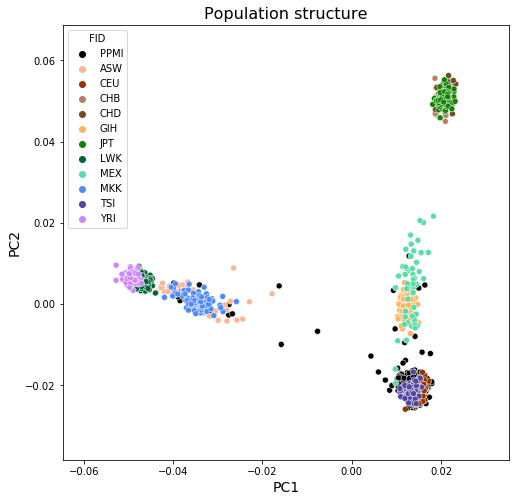

In [56]:
def assign_pop(pop):
    if pop.isdigit():
        return "PPMI"
    return pop
hp_pca["FID"] = hp_pca.apply(lambda x : assign_pop(x[0]), axis=1)

# plot population structure
palette = [
    "#000000", 
    "#fbb696", 
    "#913502", 
    "#b48060", 
    "#724a20", 
    "#ffb55f", 
    "#108300", 
    "#006435", 
    "#59dda7", 
    "#508aff", 
    "#53459f", 
    "#cd87ff"
]

# PC1 vs PC2
plt.figure(figsize=(8,8))
sns.scatterplot(data=hp_pca, x="PC1", y="PC2", hue="FID", palette=palette)
plt.title("Population structure", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)

Text(0, 0.5, 'PC3')

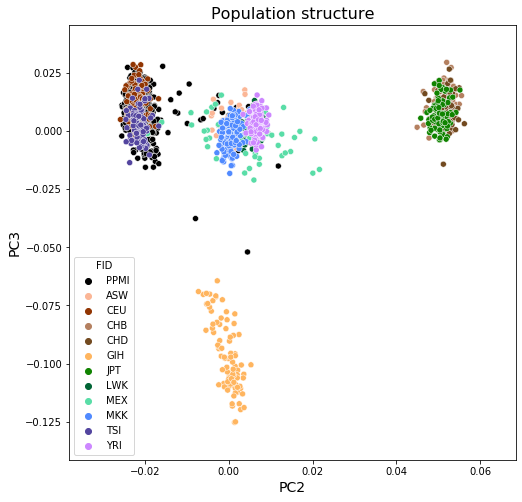

In [57]:
# PC2 vs PC3
plt.figure(figsize=(8,8))
sns.scatterplot(data=hp_pca, x="PC2", y="PC3", hue="FID", palette=palette)
plt.title("Population structure", size=16)
plt.xlabel("PC2", size=14)
plt.ylabel("PC3", size=14)

We now select only those subjects of European (CEU and TSI) ancestry.

In [58]:
# we measure the distance from the central european (CEU) and italian (TSI) cluster
hp_ceu = hp_pca[(hp_pca.FID =='CEU') | (hp_pca.FID =='TSI')]
ceu_means = hp_ceu.loc[:,'PC1':'PC5'].apply(np.mean)
ceu_sds   = hp_ceu.loc[:,'PC1':'PC5'].apply(np.std)

#compute z-scores for PPMI subjects
ppmi_pca = hp_pca[hp_pca.FID == "PPMI"]
ppmi_ceu_z = ppmi_pca.loc[:,'PC1':'PC5'].apply(lambda x: (x - ceu_means)/ceu_sds, axis=1)

ppmi_ceu_z.head()

,PC1,PC2,PC3,PC4,PC5
0,0.049471,-0.437687,-0.339140,-1.000899,0.145310
1,0.097057,-0.672377,0.182176,0.268751,0.305452
2,-0.336265,1.258896,-0.048404,0.497407,0.628326
3,1.028431,-0.598568,-0.271582,-0.958484,0.441488
4,1.661231,1.772199,-1.046118,-0.371996,-0.253007


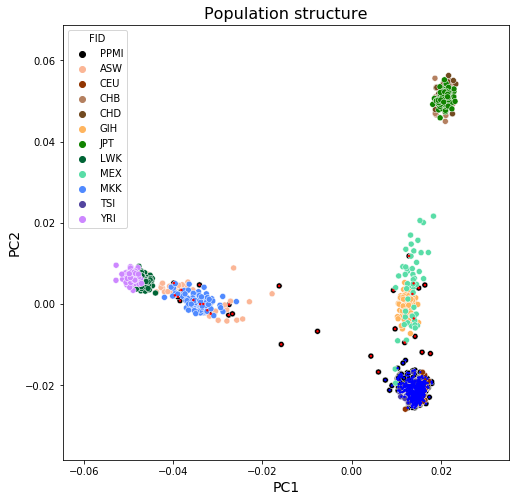

In [70]:
keep_ppmi = ppmi_ceu_z.apply(lambda x: abs(x) > 6).apply(np.sum,axis=1) == 0

ppmi_color=["b"] * len(keep_ppmi)
idx = [i for i, x in enumerate(keep_ppmi.values) if not x]
for i in idx:
    ppmi_color[i] = "r"

cuse = hp_pca.apply(lambda x: "#000000", axis=1)
plt.figure(figsize=(8,8))
sns.scatterplot(data=hp_pca, x="PC1", y="PC2", hue="FID", palette=palette)
plt.scatter(ppmi_pca.PC1, ppmi_pca.PC2, s=2, c=ppmi_color)
plt.title("Population structure", size=16)
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.show()

In [71]:
ppmi_pca_ceu = ppmi_pca[keep_ppmi]
pd.DataFrame(
    zip(ppmi_pca_ceu.IID.tolist(), ppmi_pca_ceu.IID.tolist())
).to_csv(
    "data/genotyping/ceu_subjs.txt",
    sep=" ",
    index=False,
    header=False
)

# call plink
!plink --bfile {"_".join([ppmi_merge_fn, "snp"])} --keep data/genotyping/ceu_subjs.txt --make-bed --out {"_".join([ppmi_merge_fn, "ceu"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_ceu.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_snp
  --keep data/genotyping/ceu_subjs.txt
  --make-bed
  --out data/genotyping/PPMI_merge_ceu

16384 MB RAM detected; reserving 8192 MB for main workspace.
153609 variants loaded from .bim file.
511 people (341 males, 170 females) loaded from .fam.
--keep: 480 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 480 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.99786.
153609 variants and 480 people pass filters and QC.
Note: N

We can now recover the subset of samples with complete genotyping, transcriptomic and neuroimaging data for the following analyses. <br>
We also recompute the first 20 PCs of the relatedness matrix which will be used during SNP-phenotype associations.

In [68]:
!plink --bfile {"_".join([ppmi_merge_fn, "ceu"])} --keep {os.path.join(pheno_path, "rnaseq_subjs.txt")} --make-bed --out {os.path.join(genotyping_path, "PPMI_merge_final")} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_final.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_ceu
  --keep data/pheno/rnaseq_subjs.txt
  --make-bed
  --out data/genotyping/PPMI_merge_final

16384 MB RAM detected; reserving 8192 MB for main workspace.
153609 variants loaded from .bim file.
478 people (320 males, 158 females) loaded from .fam.
--keep: 260 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 260 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.997763.
153609 variants and 260 people pass filters and QC.
Note

In [69]:
!plink --bfile {os.path.join(genotyping_path, "PPMI_merge_final")}  --pca 20 --out {os.path.join(genotyping_path, "PPMI_merge_final")} 

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/genotyping/PPMI_merge_final.log.
Options in effect:
  --bfile data/genotyping/PPMI_merge_final
  --out data/genotyping/PPMI_merge_final
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
153609 variants loaded from .bim file.
260 people (168 males, 92 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 260 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997763.
153609 variants and 260 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved to d